In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
# from torch.utils.tensorboard import SummaryWriter
import json
import matplotlib.pyplot as plt
from models.resnet import *
from models.mobilenetv2 import *
from models import *
import numpy as np

In [23]:
class Args:
    def __init__(self):
        self.his = './his/res50_1_per_channel_tntupload.json'
        self.savepath = './encoding/mobilev2_1_per_channel'
        self.model_name = 'mobilev2_norm'

args = Args()

In [2]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

testset = torchvision.datasets.CIFAR10(
    root='/data/datasets/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
model = torch.load("./result45/ep90_mobile_class5client10.ckpt")

In [4]:
ModelClassDict = {
    'res50_norm': ResNet50,
    'res50_tnt': ResNet_TNT50,
    'vgg_norm': VGG_norm,
    'vgg_tnt':VGG_tnt,
    'mobilev2_norm': MobileNetV2,
    'mobilev2_tnt': MobileNetV2_tnt,
#     'lenet': LeNet_tnt,
    'alex': AlexNet, 
    'alex_tnt': AlexNet_tnt
}

In [28]:
device = torch.device('cuda')
net = ModelClassDict['mobilev2_tnt'](10).half()
net.to(device)

MobileNetV2_tnt(
  (conv1): TNTConv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): TNTBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): TNTConv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): TNTBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): TNTConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): TNTBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): TNTConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): TNTBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): TNTConv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): TNTBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [29]:
net.load_state_dict(model['net'])

<All keys matched successfully>

In [30]:
conv2d = {}
linear = {}
for name, module in net.named_modules():
    if isinstance(module, TNTConv2d):
        conv2d[name] = module.weight
    if isinstance(module, TNTLinear):
        linear[name] = module.weight

In [31]:
def autolabel(weights):
    x_sta = np.array(weights)

    pos_mean = np.mean(x_sta[x_sta > 0])
    pos_var = np.var(x_sta[x_sta > 0])
    pos_num = sum((x_sta > 0) * 1)
    
    neg_mean = np.mean(x_sta[x_sta < 0])
    neg_var = np.var(x_sta[x_sta < 0])
    neg_num = sum((x_sta < 0) * 1)
    
    zero_num = x_sta[x_sta == 0]
    num_items = set(x_sta.flatten())
    out_dict = {
        'pos_mean': pos_mean,
        'pos_var': pos_var,
        'pos_num': pos_num,
        'neg_mean': neg_mean,
        'neg_var': neg_var,
        'neg_num': neg_num,
        'zero_num': zero_num,
        'num_items': num_items
    }
    return out_dict

In [32]:
def weights_dis(weight_dic):
    for key in weight_dic.keys():
        if len(weight_dic[key].size()) == 4:
            o, i, h, w = weight_dic[key].size()
        else:
            o, i = weight_dic[key].size()
        arr = weight_dic[key].reshape(-1).cpu().detach().numpy()
        plt.figure(figsize=(10, 5))
        plt.hist(arr, bins=50, range=(-0.05, 0.05))
        out = autolabel(arr)
        plt.title(f'weights of {key}')
        plt.axvline(x=out["pos_mean"])
        plt.axvline(x=out["neg_mean"])
        plt.text(out["pos_mean"], len(out['zero_num'])*0.3,
                 f'mean: {out["pos_mean"]:.3e}\n'
                 f'var: {out["pos_var"]:.3e}\n'
                 f'num: {out["pos_num"]}\n')
        
        plt.text(out["neg_mean"], len(out['zero_num'])*0.3,
                 f'mean: {out["neg_mean"]:.3e}\n'
                 f'var: {out["neg_var"]:.3e}\n'
                 f'num: {out["neg_num"]}')
        
        plt.text(0.002, len(out['zero_num'])*0.3,
                 f'zero_num: {len(out["zero_num"])}\n'
                 f'num diff items: {len(out["num_items"])}')
        plt.ylim((0, len(out['zero_num'])*0.5))
        plt.show()

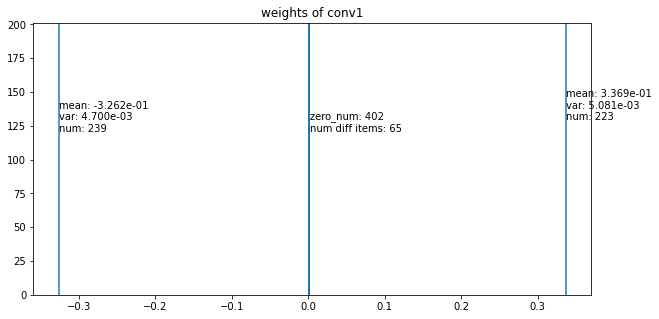

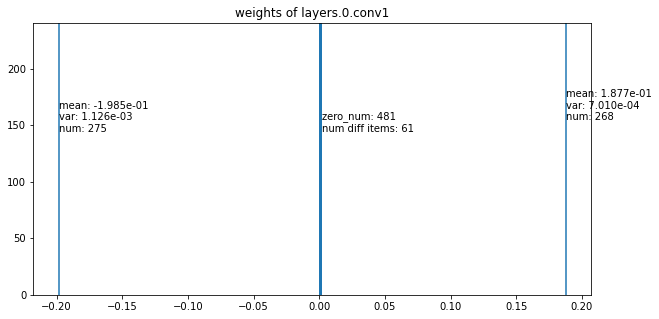

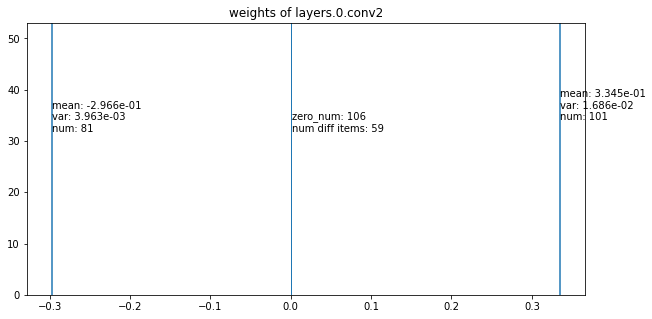

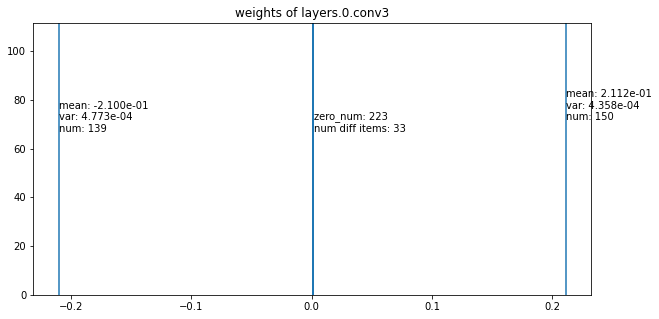

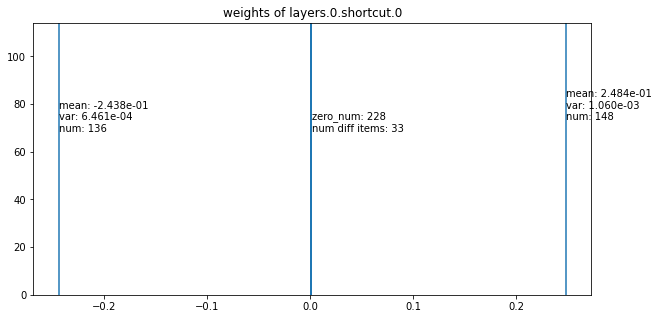

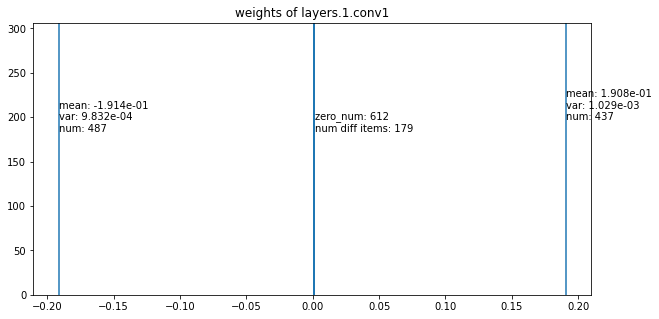

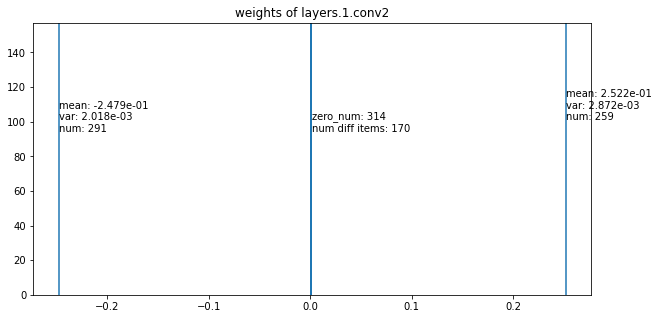

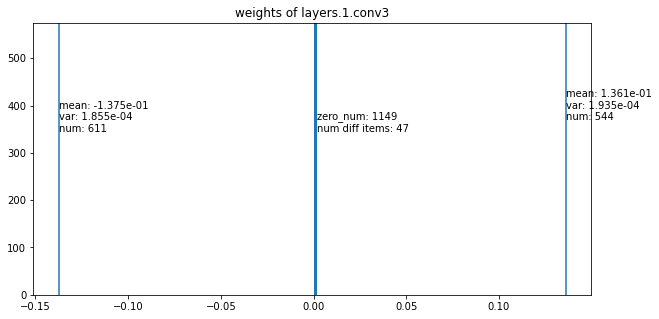

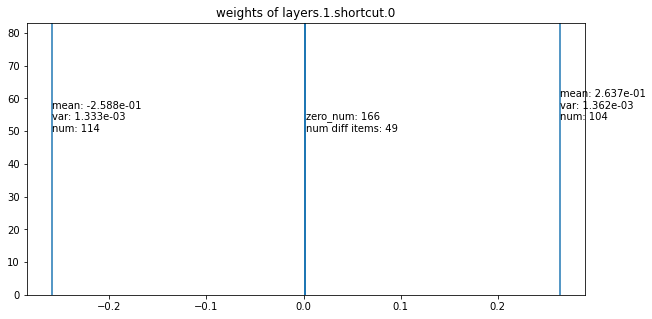

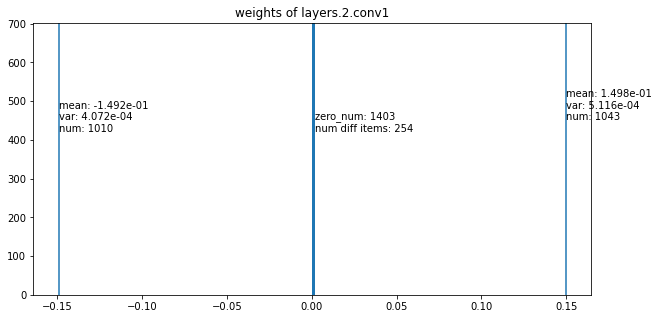

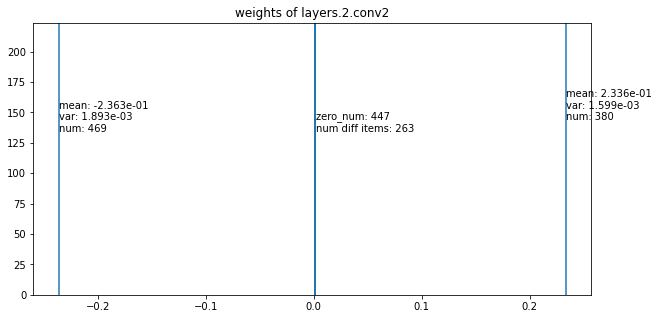

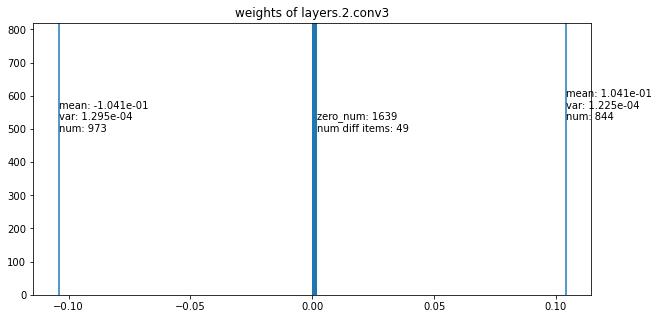

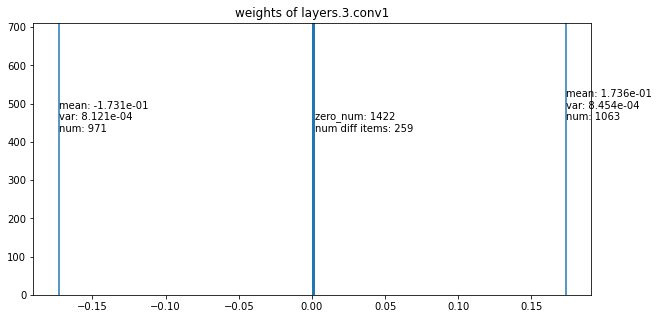

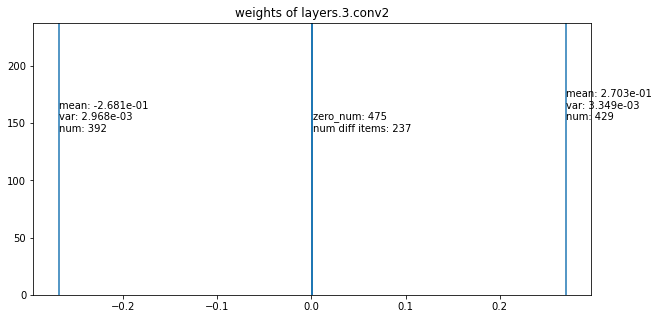

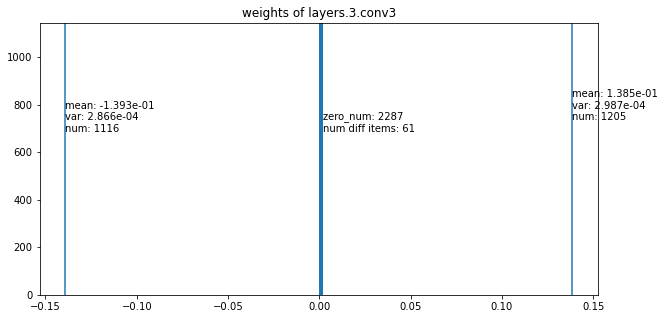

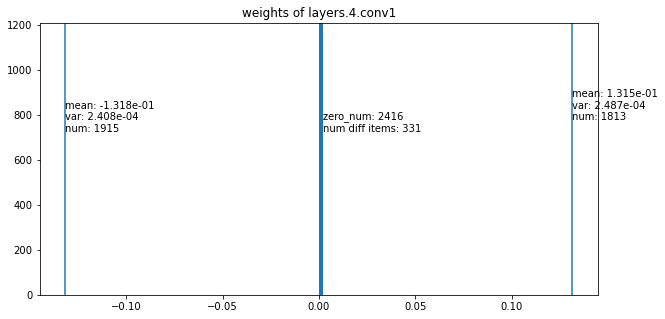

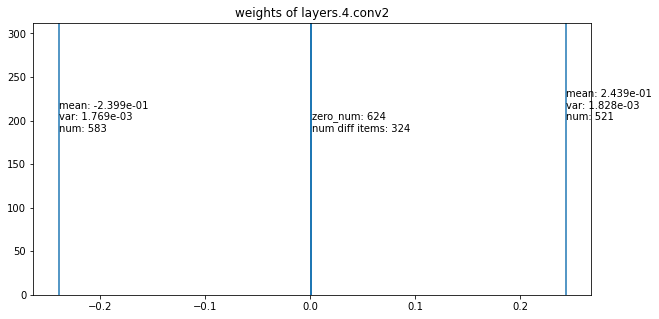

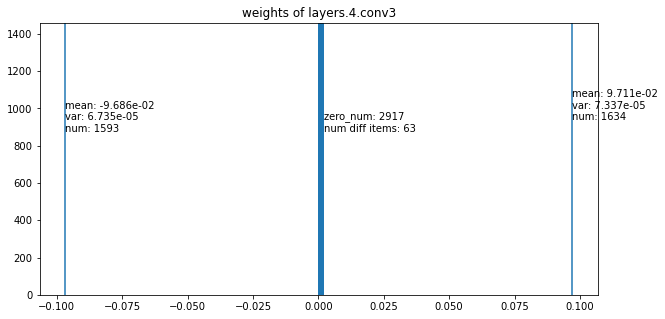

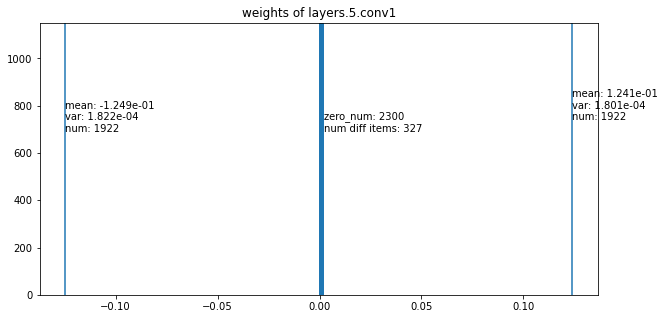

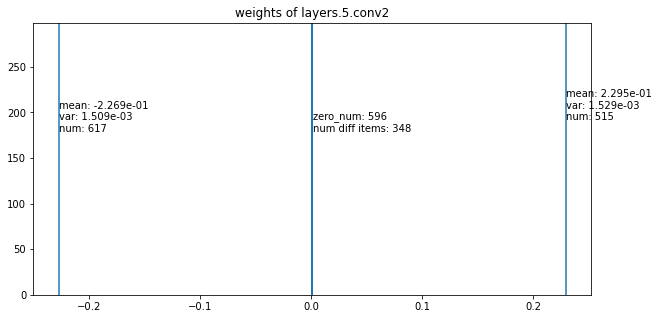

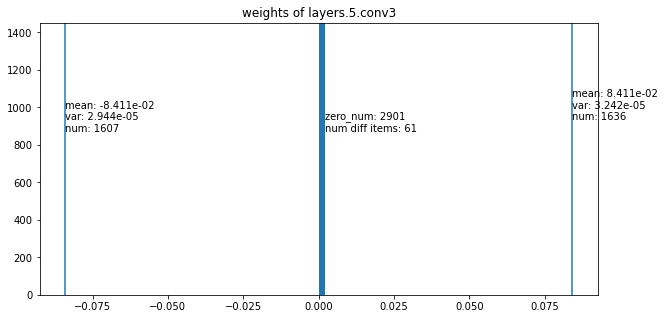

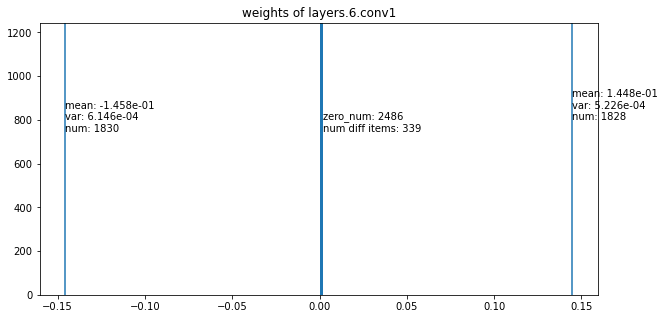

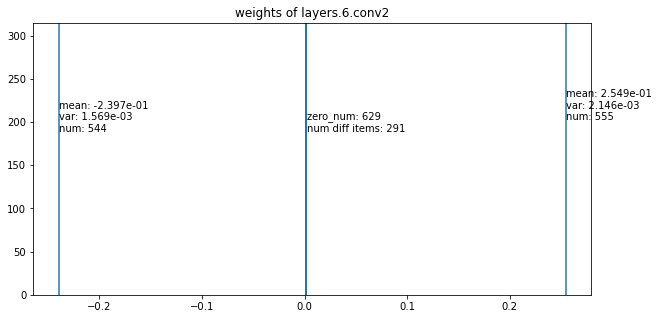

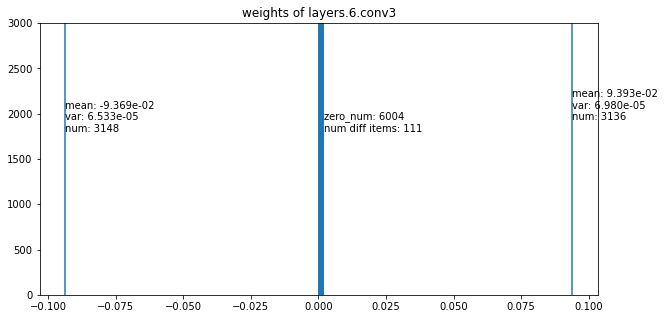

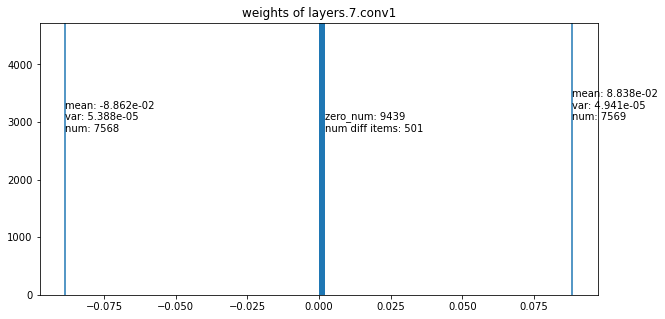

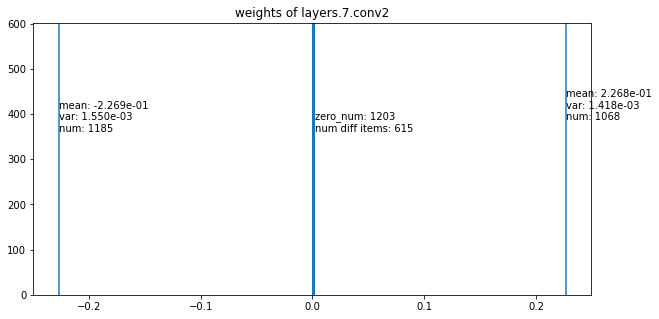

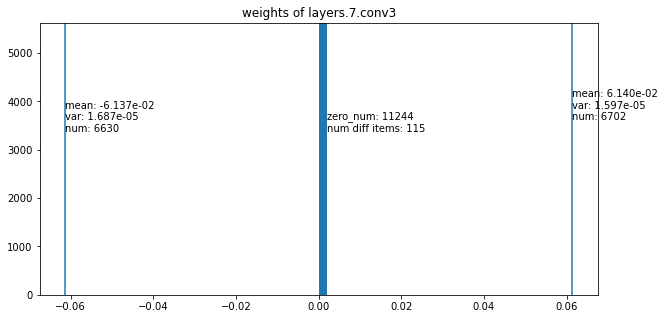

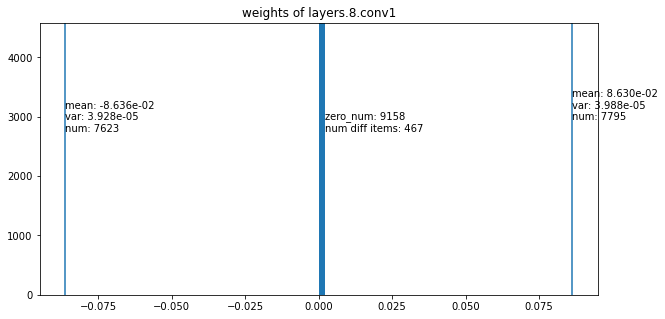

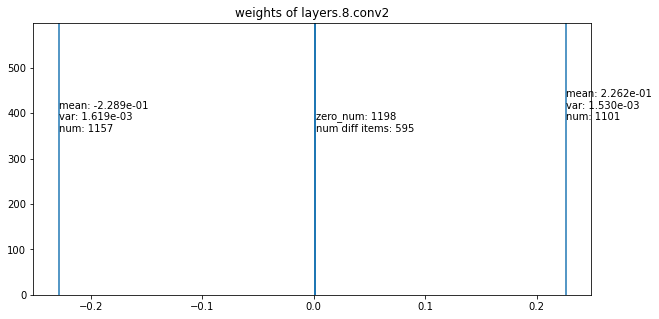

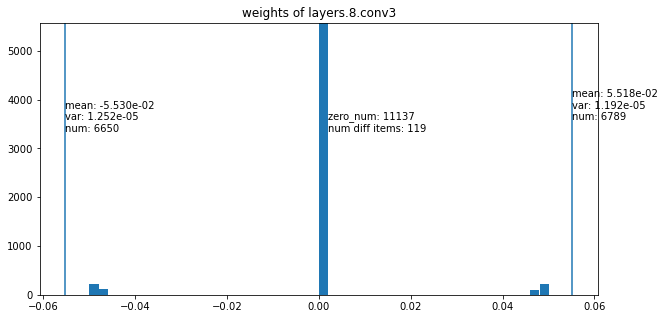

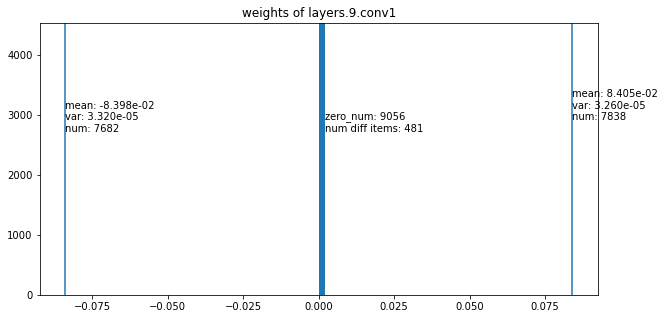

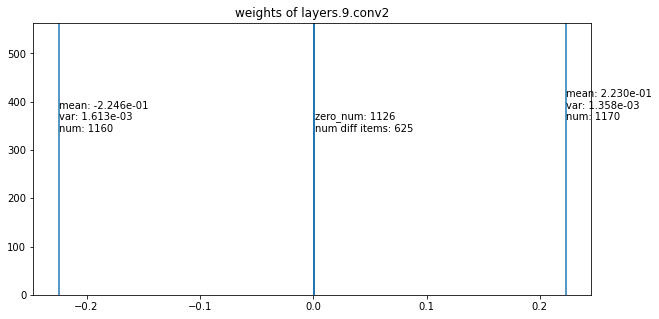

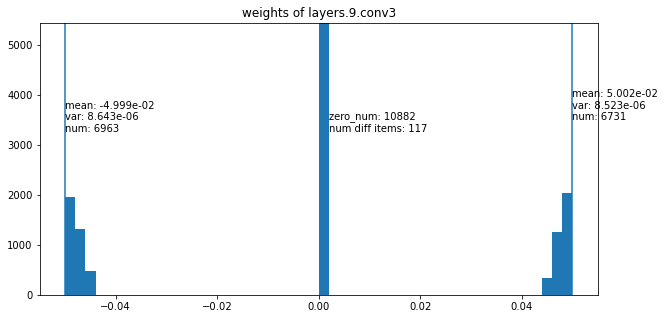

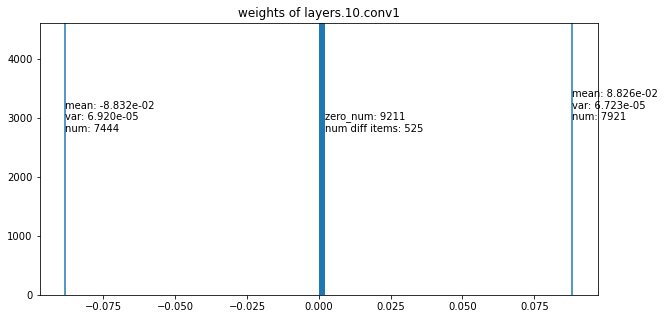

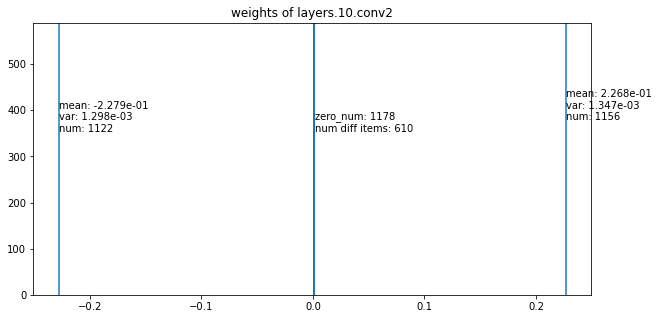

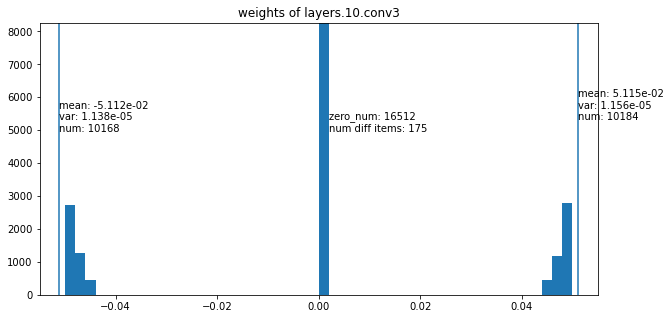

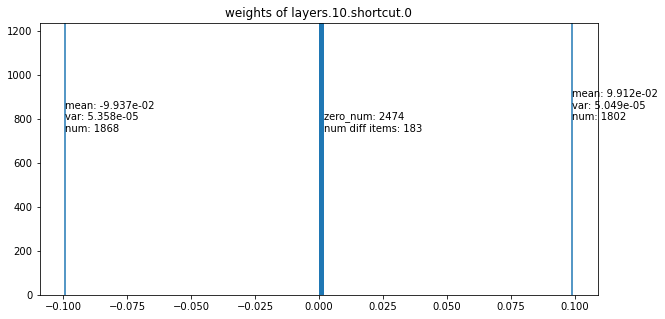

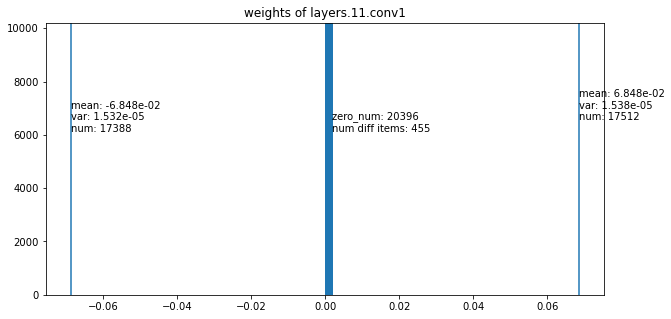

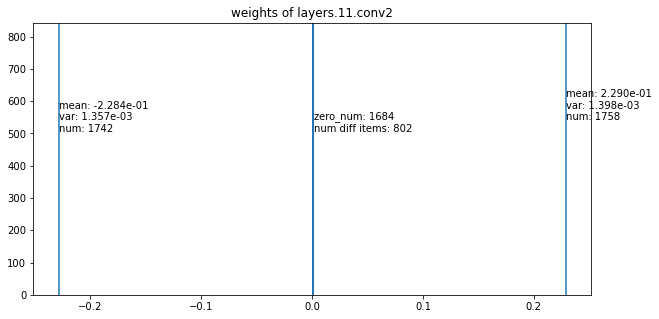

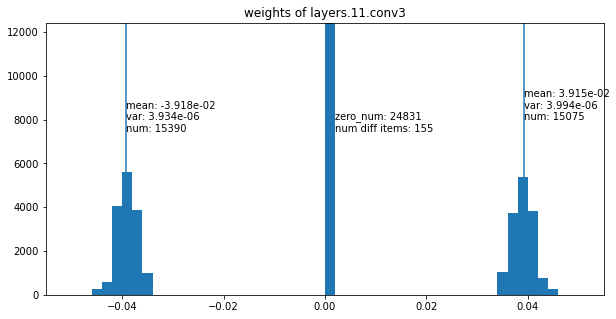

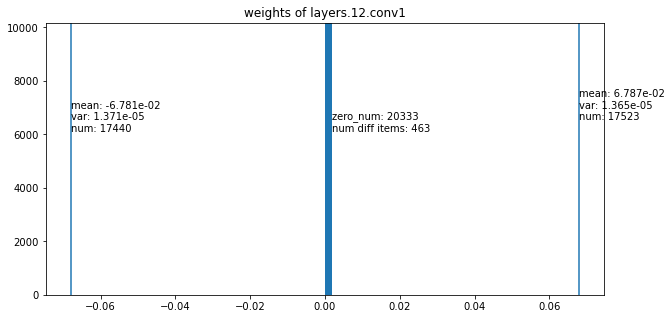

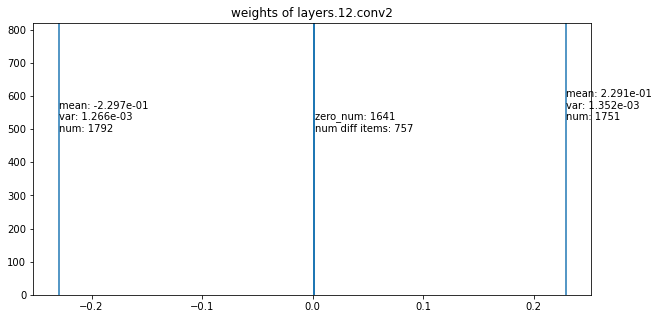

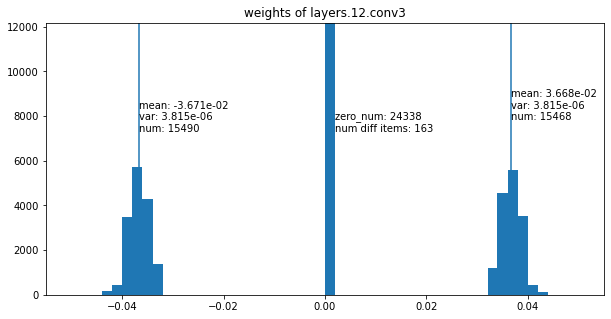

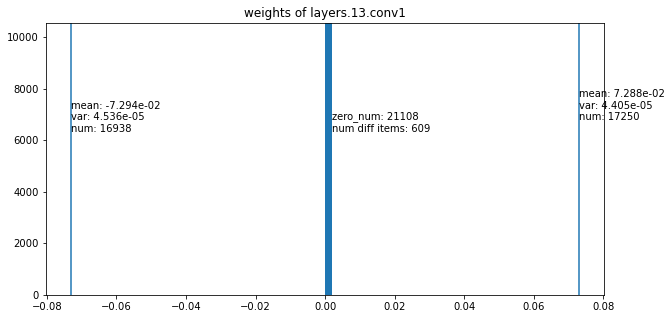

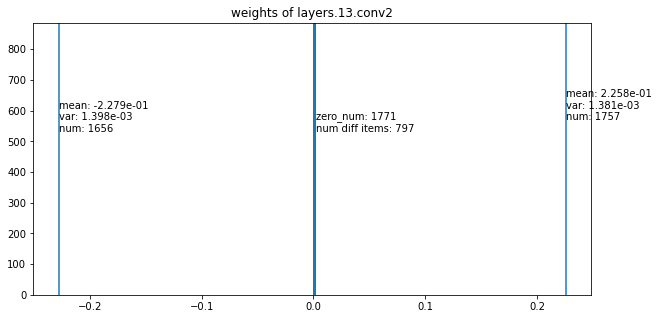

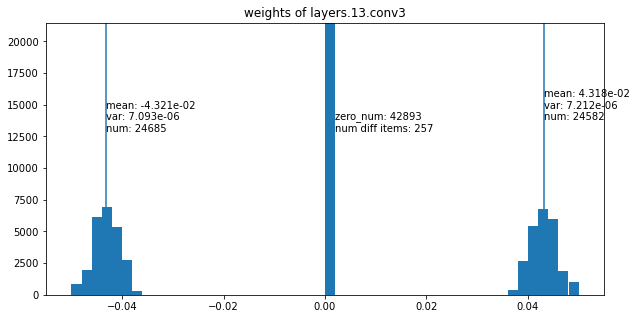

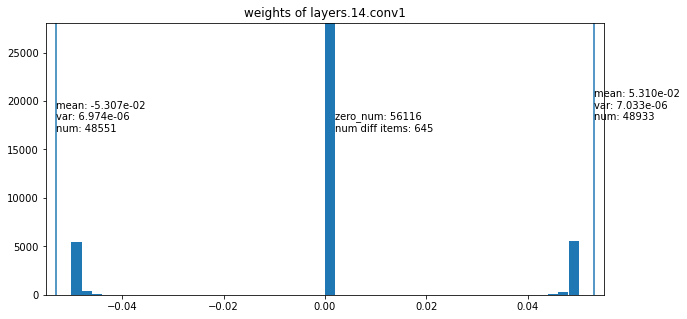

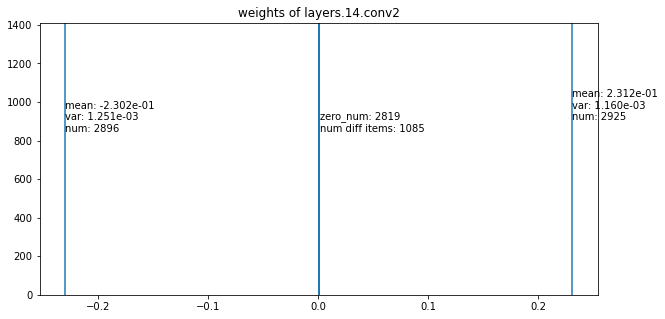

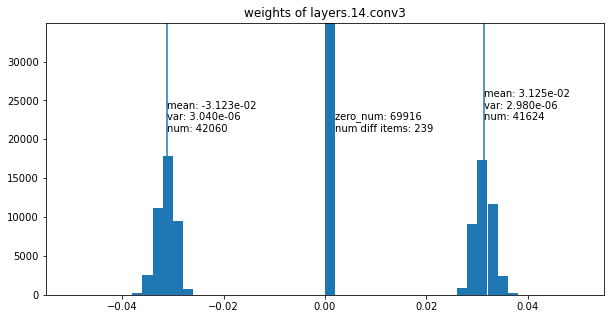

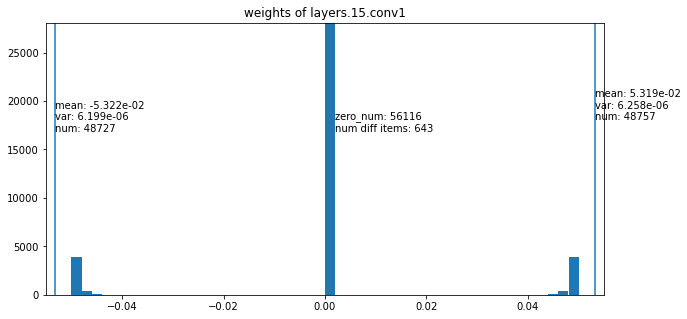

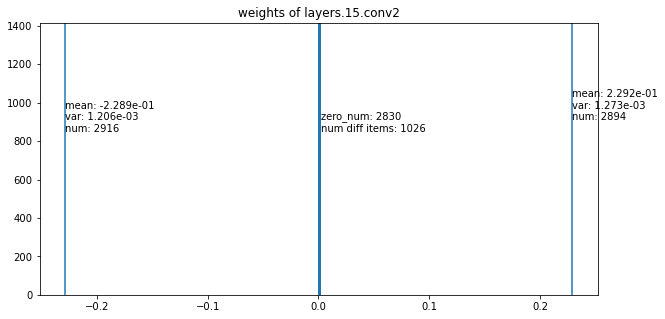

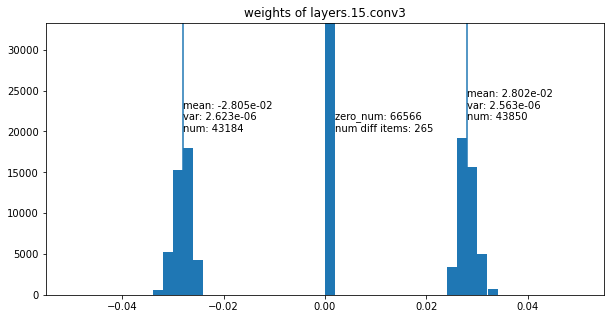

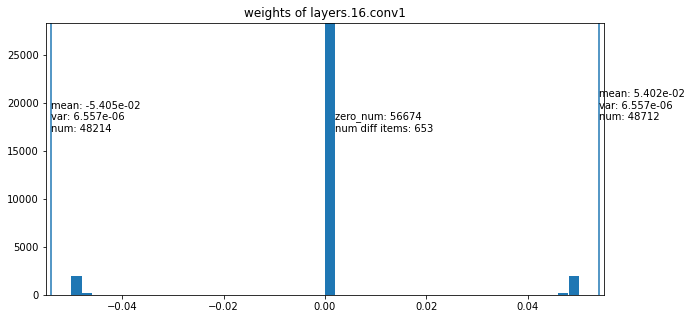

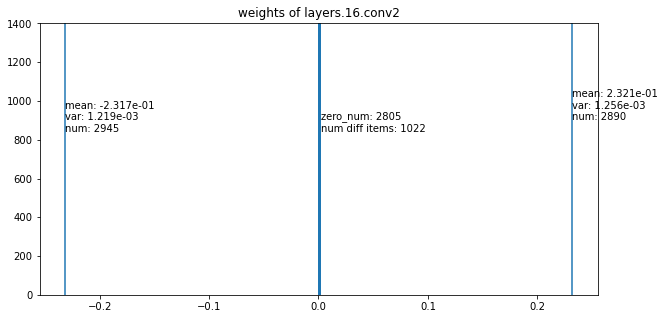

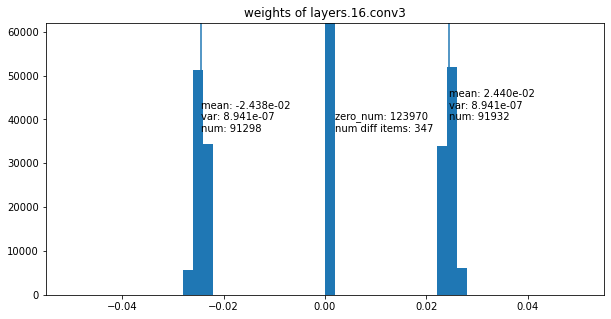

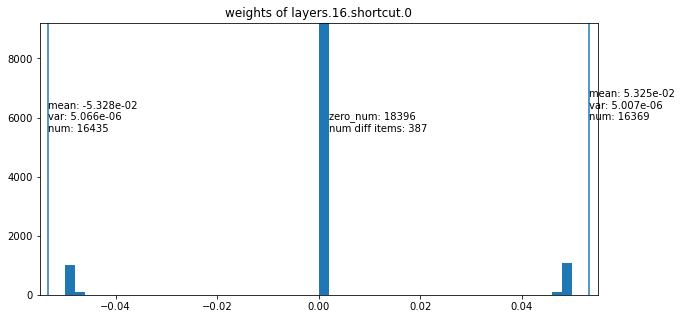

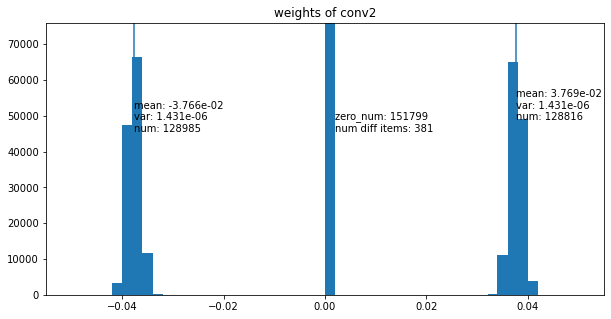

In [33]:
weights_dis(conv2d)

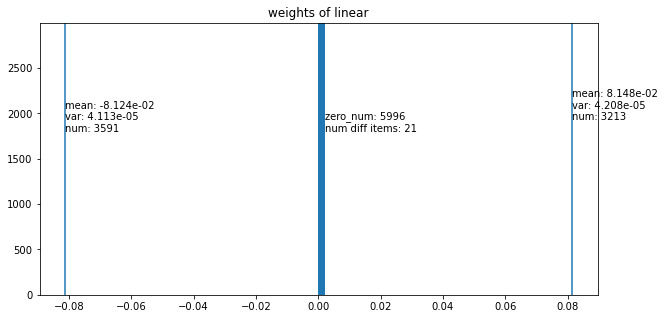

In [34]:
weights_dis(linear)

In [35]:
w = copy.deepcopy(net.state_dict())
for name, module in net.named_modules():
    if isinstance(module, TNTConv2d):
        w[name + str('.weight')] = KernelsCluster.apply(module.weight)
    if isinstance(module, TNTLinear):
        w[name + str('.weight')] = KernelsCluster.apply(module.weight)

In [36]:
for k in w.keys():
    total_params = 0
    zero_params = 0
    for key in w.keys():
        zero_params += (w[key].view(-1) == 0).sum().item()
        total_params += len(w[key].view(-1))
print(zero_params / total_params)

0.3855146528808992


In [37]:
total_params = 0
zero_params = 0
for val in model['net'].values():
    shape = (list(val.data.shape))
    size = 1
    for u in shape:
        size *= u
    total_params += size
    zero_params += (val.data==0).long().sum()

print('Compression rate is {:.2%}'.format(zero_params.item() / total_params))
print((total_params - zero_params.item()) / (1024 * 1024)) 

Compression rate is 38.55%
1.3666353225708008


In [14]:
with open(r'C:\Users\alvin\Documents\ternay_compression\azurevm\training\his/alex16_ternary_noniid_class2_tnt_image_Bychanel.json', 'r') as outfile:
    a = json.load(outfile)

Max test Acc. 38.55% at epoch 93


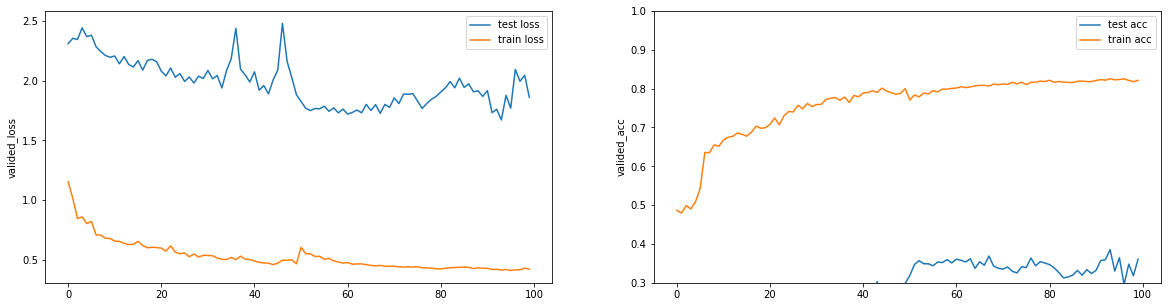

In [15]:
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
plt.sca(ax1)
plt.plot(range(len(a['test_loss'])), a['test_loss'], label='test loss')
plt.plot(range(len(a['train_loss'])), a['train_loss'], label='train loss')
plt.ylabel('valided_loss')
plt.legend()

norm_his_acc = a['test_correct']
norm_train_acc = a['train_accuracy']
plt.sca(ax2)
plt.plot(range(len(norm_his_acc)), norm_his_acc, label='test acc')
plt.plot(range(len(norm_train_acc)), norm_train_acc, label='train acc')
plt.ylim(0.3, 1)
plt.ylabel('valided_acc')
plt.legend()

norm_acc = max(a['test_correct'])
print('Max test Acc. {:.2%} at epoch {}'.format(norm_acc, norm_his_acc.index(max(norm_his_acc))))

Max cr. 26.74% at epoch 0


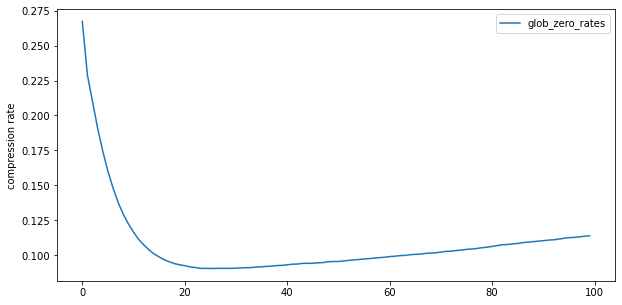

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(a['glob_zero_rates'])), a['glob_zero_rates'], label="glob_zero_rates")
plt.ylabel('compression rate')
plt.legend()
cr = max(a['glob_zero_rates'])
print('Max cr. {:.2%} at epoch {}'.format(cr, a['glob_zero_rates'].index(max(a['glob_zero_rates']))))

In [58]:
criterion = nn.CrossEntropyLoss()

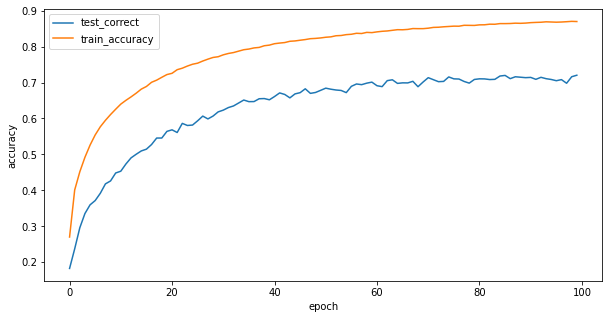

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(a["test_correct"])), a['test_correct'], label="test_correct")
plt.plot(range(len(a['train_accuracy'])), a['train_accuracy'], label="train_accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

In [59]:
net.eval().half()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device).half(), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
print((correct/total) * 100)

NameError: name 'net' is not defined

In [60]:
print(a.keys())

dict_keys(['train_loss', 'train_accuracy', 'test_loss', 'test_correct', 'train_time', 'glob_zero_rates', 'local_zero_rates'])


In [12]:
from huffmancoding import *

ModuleNotFoundError: No module named 'huffmancoding'

In [24]:
savepath = args.savepath

In [25]:
weights_dic = net.get_tnt()
net.load_state_dict(weights_dic)

AttributeError: 'MobileNetV2' object has no attribute 'get_tnt'

In [26]:
huffman_encode_model(net, savepath)

Layer           |   original compressed improvement percent
----------------------------------------------------------------------
(32, 3, 3, 3)
(32, 27)
conv1.weight    |       7024       5419       1.30x  77.15%
(32,)
(32, 1)
bn1.weight      |        264        323       0.82x 122.35%
bn1.bias        |        128        128       1.00x 100.00%
(32, 32, 1, 1)
(32, 32)
layers.0.conv1.weight |       3980       1125       3.54x  28.27%
(32,)
(32, 1)
layers.0.bn1.weight |        264        323       0.82x 122.35%
layers.0.bn1.bias |        128        128       1.00x 100.00%
(32, 1, 3, 3)
(32, 9)
layers.0.conv2.weight |       2344       1847       1.27x  78.80%
(32,)
(32, 1)
layers.0.bn2.weight |        264        323       0.82x 122.35%
layers.0.bn2.bias |        128        128       1.00x 100.00%
(16, 32, 1, 1)
(16, 32)
layers.0.conv3.weight |       1868        610       3.06x  32.66%
(16,)
(16, 1)
layers.0.bn3.weight |        136        163       0.83x 119.85%
layers.0.bn3.bias |       

In [27]:
import os

In [28]:
state = os.stat(savepath)
size = 0
for _, l, k in os.walk(savepath):
    for j in range(len(k)):
        file = os.path.join(savepath, k[j])
        state = os.stat(file)
        size += state.st_size / (1024 * 1024)
print(size)

4.295415878295898


In [29]:
args.model

'./checkpoint/mobilev2_1_per_channel_tntupload.ckpt'

In [30]:
file_state = os.stat(args.model)

In [31]:
file_state.st_size / (1024 * 1024)

8.954565048217773